<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

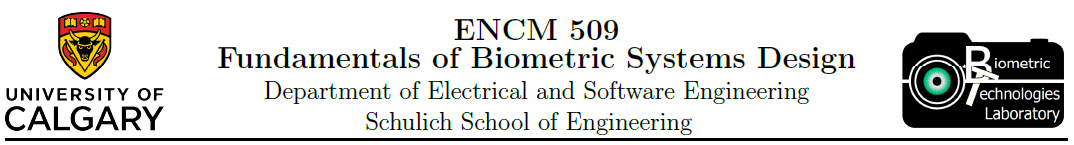

# ENCM 509 Final Project - Speech Recognition
Chace Nielson - 30045674 <br/>
Emmanuel Omari-Osei - 30092729 <br/>
Thanusha Veeraperumal - 30090927 <br/>


## Imports/Setup

In [1]:
# Standard library imports
import math
import os

# Third-party imports for data manipulation and numerical operations
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from scipy.io import loadmat
from scipy.stats import norm, stats, ttest_1samp, chi2
import scipy.signal as sps
from scipy.fft import rfft
from scipy.fftpack import dct

# Third-party imports for machine learning
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture

# Third-party imports for audio processing
from python_speech_features import mfcc, sigproc
import librosa

# Third-party imports for visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns


### Helper Functions

In [2]:
# Define path to the data
data_root_folder = 'AudioFiles'

# Function to get file paths for a subject
def get_files(subject, set_type):
    subject_folder = os.path.join(data_root_folder, subject)
    files = os.listdir(subject_folder)
    return [os.path.join(subject_folder, file) for file in files if set_type in file]

In [3]:
# Function to extract MFCC features and return the array of features
def extract_mfcc_features(file_paths):
    mfcc_features = []
    for file_path in file_paths:
        # Load audio file
        audio_signal, sample_rate = librosa.load(file_path, sr=None)
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)
        mfcc_features.append(mfcc.T)
    return mfcc_features

In [4]:
# This function trains a gmm model using a default 20 Gaussian components using training data and returns the Model
# it assume the training data is a list of features
def train_gmm(training_data, NUMGCOMPONENTS=20):
    # Create the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=NUMGCOMPONENTS)
    
    # Perform the training using the training data samples
    for sample in training_data:
        gmm.fit(sample)

    return gmm

In [5]:
# this function take a model and test samples and returns there scores and labels
# the labels are not used as a different methods to find the predictions and labels was used
def test_samples(gmm_model, test_samples):
    # Make array lists for predictions and scores
    test_scores = []
    prediction_labels = []

    # Iterate through test samples:
    for test_sample in test_samples:

        # Make predictions on test sample
        prediction_label = gmm_model.predict(test_sample)

        # Collect prediction scores
        test_score = gmm_model.score_samples(test_sample)

        # Append to result lists
        test_scores.append(test_score)
        prediction_labels.append(prediction_label)

    return test_scores, prediction_labels

In [6]:
# this takes the socres and flattens then to be returned to calling function
def test_data_against_gmm(gmm_model, test_data_freatures):
    # store the scores
    scores = []

    # test the sample data
    test_scores, prediction_labels = test_samples(gmm_model, test_data_freatures)

    # Flatten score and prediction lists
    flat_test_scores = [i for ix in test_scores for i in ix]
    flat_prediction_labels = [i for ix in prediction_labels for i in ix]

    return flat_test_scores, flat_prediction_labels

In [7]:
# plots 1 list of scores against another
def plot_two_score_sets_subplot(ax, name1, prob1, scores1, name2, prob2, scores2, x):
    # Plot distribution
    ax.plot(x, prob1, 'g')
    ax.plot(x, prob2, 'r')
    ax.plot(scores1, np.zeros(len(scores1)), 'g^', lw=2, label=name1)
    ax.plot(scores2, np.zeros(len(scores2)), 'ro', lw=2, label=name2)
    ax.legend()
    ax.set_title(f"{name1} Vs {name2}")

In [8]:
# plots all curves for the number of impostor/testing data used
def plot_curves(databaseUser, imposter_names, auth_Std, auth_Mu, imposter_mean_list, 
                imposter_std_list, auth_Prob, auth_test_scores, imposter_prob_list, imposter_scores_list, x):
    
    # decide the number of columns
    num_cols = 3
    num_rows = math.ceil(len(imposter_names) / num_cols)

    initial_mean_diff = round(auth_Mu - imposter_mean_list[0], 2)
    smallest_mean_diff = {"name":imposter_names[0],"mean_diff":initial_mean_diff}
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    fig.suptitle(databaseUser, fontsize=24, y=1.0)  # Adjust the y parameter to add padding below the title.

    for i, impostor in enumerate(imposter_names):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        plot_two_score_sets_subplot( ax,
                        "Authentic", auth_Prob, auth_test_scores, 
                        impostor, imposter_prob_list[i], imposter_scores_list[i],
                        x)
        mean_diff = round(auth_Mu - imposter_mean_list[i], 2)
        std_diff = round(auth_Std - imposter_std_list[i], 2)

        text = f"""Auth Mean: {round(auth_Mu, 2)}, Auth Std: {round(auth_Std, 2)}
        Test mean: {round(imposter_mean_list[i], 2)}, Test std: {round(imposter_std_list[i], 2)}
        Mean Difference: {mean_diff}, Std Difference: {std_diff}
        """
        ax.text(0.5, -0.3, text, ha='center', va='center', transform=ax.transAxes, fontsize=10)  # Adjust y as necessary.

        if mean_diff < smallest_mean_diff["mean_diff"]:
            smallest_mean_diff["mean_diff"] = mean_diff
            smallest_mean_diff["name"] = imposter_names[i]
    fig.tight_layout()
    plt.show()

    return smallest_mean_diff["name"]

In [9]:
# returns true of false based on the critical value 
def test_zscore(test_audio_mean, real_mean, real_std, critical_value=0.05):
    """
    Classify a test signature as genuine or impostor based on a critical value threshold.

    Parameters:
    test_sig (float): The signature score to be tested.
    real_mean (float): The mean score of genuine signatures.
    real_std (float): The standard deviation of genuine signatures.
    critical_value (float): The critical value for determining the threshold.

    Returns:
    bool: True if the signature is classified as genuine, False otherwise.
    """
    # Calculate the Z-score for the given critical value
    z_score = norm.ppf(1 - critical_value/2)  # Two-tailed test

    # Set the threshold based on the Z-score
    lower_bound = real_mean - z_score * real_std
    upper_bound = real_mean + z_score * real_std

    return lower_bound <= test_audio_mean <= upper_bound

In [10]:
# auth index is the index of the impostor list that contains authentic data for ease of running
def run_analysis(databaseUser, training_files, imposter_list, imposter_names, auth_index, critical_value, NUMGCOMPONENTS=20):

    # get features for training, authentic, and all imposters
    training_mfccs = extract_mfcc_features(training_files)

    impostor_features_list = []
    for imposter in imposter_list:
        impostor_features_list.append(extract_mfcc_features(imposter))

    # train the gmm
    gmm_model = train_gmm(training_mfccs, NUMGCOMPONENTS)

    auth_test_scores, auth_labels = test_data_against_gmm(gmm_model, training_mfccs)

    imposter_scores_list = []
    imposter_labels_list = []

    for imposter_features in impostor_features_list:
        score, label = test_data_against_gmm(gmm_model, imposter_features)
        imposter_scores_list.append(score)
        imposter_labels_list.append(label)

    # now we have the scores for authentic data and for multiple impostor data
    x = np.arange(-260, 100, 1)

    # Calculate Mean and Standard Deviation of Authentic Test Scores
    auth_Mu = np.mean(auth_test_scores)
    auth_Std = np.std(auth_test_scores)
    auth_Prob = norm.pdf(x, loc=auth_Mu, scale=auth_Std)

    # Calculate Mean and Standard Deviation of each of the imposters
    imposter_mean_list=[]
    imposter_std_list=[]
    imposter_prob_list=[]
    
    for imposter_scores in imposter_scores_list:
        # Calculate Mean and Standard Deviation of Imposter Test Scores
        imp_mu = np.mean(imposter_scores)
        imp_std = np.std(imposter_scores)
        imp_Prob = norm.pdf(x, loc=imp_mu, scale=imp_std)

        # add to list
        imposter_mean_list.append(imp_mu)
        imposter_std_list.append(imp_std)
        imposter_prob_list.append(imp_Prob)

    ## plot the curves
    smalled_mean_name = plot_curves(databaseUser, imposter_names, auth_Std, auth_Mu, imposter_mean_list, 
                                    imposter_std_list, auth_Prob, auth_test_scores, imposter_prob_list, imposter_scores_list, x)

    print(f"{databaseUser} Classification: {NUMGCOMPONENTS} Components")
    # perform z-score classification
    print(f"testing using Z-scores and critical value of {critical_value}\n")
    
    # Initialize counters
    TP = FP = TN = FN = 0
    
    # Initialize a list to hold the outcome strings
    outcomes = []
    
    for i, impostor in enumerate(imposter_names):
        # get the mean of the imposter and then use it to compare
        test_mu = imposter_mean_list[i]
        match_value = test_zscore(test_mu, auth_Mu, auth_Std, critical_value)
        if i == auth_index:  # Assuming auth_index is the index of the authentic case
            if match_value:
                outcomes.append(f"{impostor} is a True Positive - Authentic Data")
                TP += 1
            else:
                outcomes.append(f"{impostor} is a False Negative - Failed to Recognize Authentic Data")
                FN += 1
        else:
            if match_value:
                outcomes.append(f"{impostor} is a False Positive")
                FP += 1
            else:
                outcomes.append(f"{impostor} is a True Negative")
                TN += 1

    # Create the confusion matrix
    conf_matrix = np.array([[TP, FP], [FN, TN]])
    
    # Plotting the confusion matrix
    fig, ax = plt.subplots()
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    # Explicitly setting the ticks before setting the labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    
    # Setting up the axes labels
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    
    # Labeling the axes
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
     # Adding text labels with outlines
    for (i, j), val in np.ndenumerate(conf_matrix):
        text = ax.text(j, i, f'{val}', ha='center', va='center', color='white', fontsize=18)
        # Apply path effects to the text to give it a black outline
        text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])

    # Calculations and print statements
    # Function to safely perform division and handle division by zero
    def safe_divide(numerator, denominator):
        return numerator / denominator if denominator else float('nan')  # Return NaN if denominator is 0

    
    # Calculate metrics
    accuracy = safe_divide(TP + TN, TP + TN + FP + FN) * 100
    precision = safe_divide(TP, TP + FP) * 100
    recall = safe_divide(TP, TP + FN) * 100  # Recall is the same as True Positive Rate (TPR)
    specificity = safe_divide(TN, TN + FP) * 100
    f1_score = safe_divide(2 * (precision * recall), (precision + recall))  # Note: precision and recall need to be in their percentage form here
    error_rate = safe_divide(FP + FN, TP + TN + FP + FN) * 100
    false_positive_rate = safe_divide(FP, FP + TN) * 100
    false_negative_rate = safe_divide(FN, FN + TP) * 100
    
    # Generate text for metrics to display beside the plot
    metrics_text = f"""
Accuracy: {accuracy:.2f}%
Precision: {precision:.2f}%
Recall (TPR): {recall:.2f}%
Specificity (TNR): {specificity:.2f}%
F1 Score: {f1_score:.2f}%
Error Rate: {error_rate:.2f}%
False Positive Rate (FPR): {false_positive_rate:.2f}%
False Negative Rate (FNR): {false_negative_rate:.2f}%
"""

    # Combine all text into one block
    combined_text = metrics_text + "\nOutcomes:\n" + "\n".join(outcomes) + \
                    f"\n\n{smalled_mean_name} has the closest mean to the training data mean\n"
    
    # Adding combined text beside the plot
    plt.text(2.5, 0.5, combined_text, fontsize=12, verticalalignment='center', horizontalalignment='left')

    plt.show()
        

## Collect Data
Get all the training and testing data for all the audio sources and set up a list of all the testing data/impostor sets

It should be noted that the imposter_tests will also include 1 authentic testing set

In [11]:
# set up files for various tests using  different users as training and for validation and testing
Emmanuel_train_files = get_files("EmmanuelAudio", "train")
Emmanuel_test_files = get_files("EmmanuelAudio", "test")

Chace_train_files = get_files("ChaceAudio", "train")
Chace_test_files = get_files("ChaceAudio", "test")

Thanusha_train_files = get_files("ThanushaAudio", "train")
Thanusha_test_files = get_files("ThanushaAudio", "test")

Subject1_train_files = get_files("Subject1", "train")
Subject1_test_files = get_files("Subject1", "test")

Subject2_train_files = get_files("Subject2", "train")
Subject2_test_files = get_files("Subject2", "test")

Subject3_train_files = get_files("Subject3", "train")
Subject3_test_files = get_files("Subject3", "test")

JackJohnson_train_files = get_files("JackJohnson", "train")
JackJohnson_test_files = get_files("JackJohnson", "test")

JackHammer_train_files = get_files("JackHammer", "train")
JackHammer_test_files = get_files("JackHammer", "test")

BluesMusic_train_files = get_files("BluesMusic", "train")
BluesMusic_test_files = get_files("BluesMusic", "test")

# set up imposters for all the tests - will also contain authentic testing data 
imposter_tests = [
                Emmanuel_test_files,
                Chace_test_files,
                Thanusha_test_files,
                Subject1_test_files,
                Subject2_test_files,
                Subject3_test_files,
                JackJohnson_test_files,
                JackHammer_test_files,
                BluesMusic_test_files
                ]
imposter_names = [
                "EmmanuelAudio",
                "ChaceAudio",
                "ThanushaAudio",
                "Subject1",
                "Subject2",
                "Subject3",
                "JackJohnson",
                "JackHammer",
                "BluesMusic",
                ]

In [12]:
print("Emmanuel training files", Emmanuel_train_files)
print("Emmanuel testing files", Emmanuel_test_files)
print("\nChace training files", Chace_train_files)
print("Chace testing files", Chace_test_files)
print("\nAll the other files contain one training file and one testing file")

Emmanuel training files ['AudioFiles/EmmanuelAudio/train.wav']
Emmanuel testing files ['AudioFiles/EmmanuelAudio/test_2.wav', 'AudioFiles/EmmanuelAudio/test_3.wav', 'AudioFiles/EmmanuelAudio/test_4.wav', 'AudioFiles/EmmanuelAudio/test_5.wav', 'AudioFiles/EmmanuelAudio/test.wav']

Chace training files ['AudioFiles/ChaceAudio/train.wav']
Chace testing files ['AudioFiles/ChaceAudio/test.wav']

All the other files contain one training file and one testing file


## Run Analysis
Each run uses a different subject's audio for the training. It is compared to all the available audio including the testing audio from the same subject for validation  

The training file is longer (about 1 minute) and the testing files are much shorter (about 10 seconds). For the last 3 training models, the training and testing are similar in length 

Ennamual and Thanusha's Audio contains multiple testing files, which ultimately amounts to a longer testing file as more feature data can be collected.

Overall there are 9 training models created in total. Each training model is tested against testing data from 8 imposters and 1 authentic data set. This results in accuracy and error rates for all 9 models. The results of these trials will be discussed at length in the report

Training data is Emmanuels training data and its authentic testing data is multiple shorter audio clips.


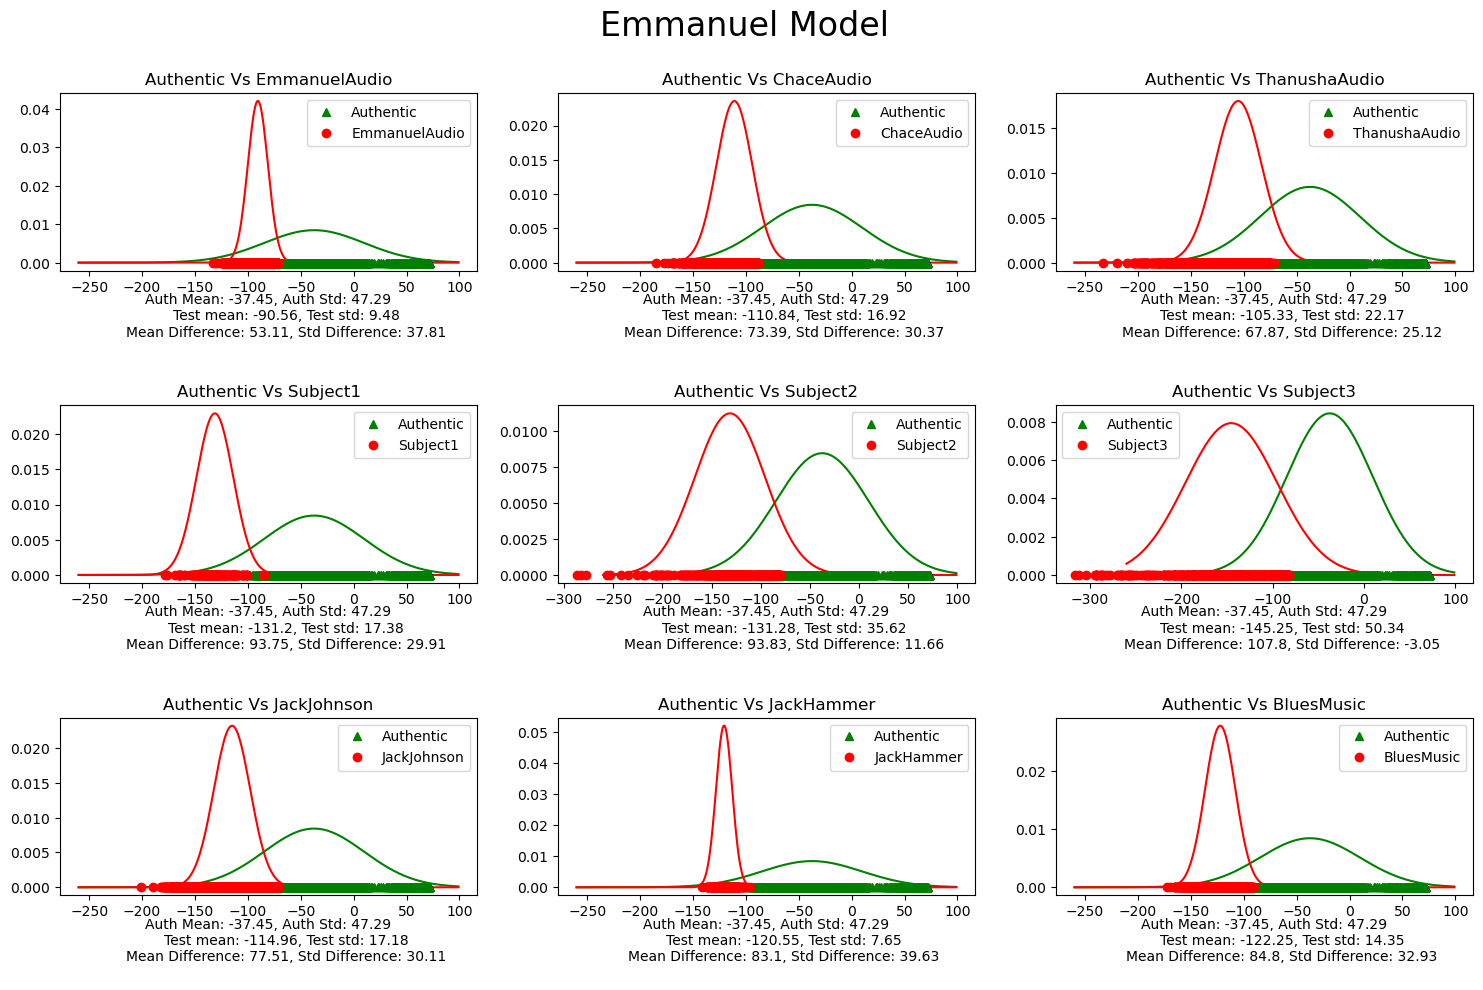

Emmanuel Model Classification: 20 Components
testing using Z-scores and critical value of 0.16



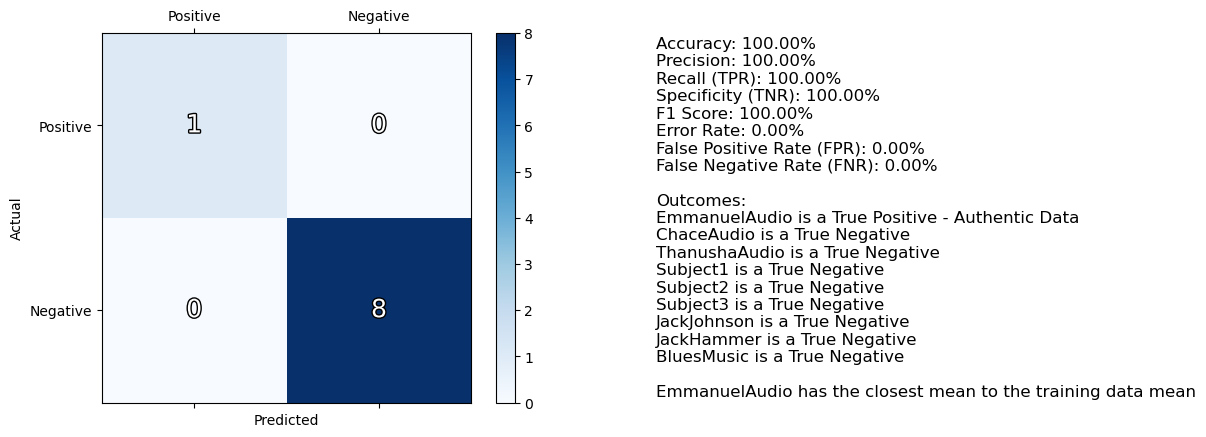

In [13]:
print("Training data is Emmanuels training data and its authentic testing data is multiple shorter audio clips.")
run_analysis("Emmanuel Model",Emmanuel_train_files, imposter_tests, imposter_names, auth_index=0, critical_value=0.16)

Training data is Chaces training data and its authentic testing data is a single shorter audio clip.


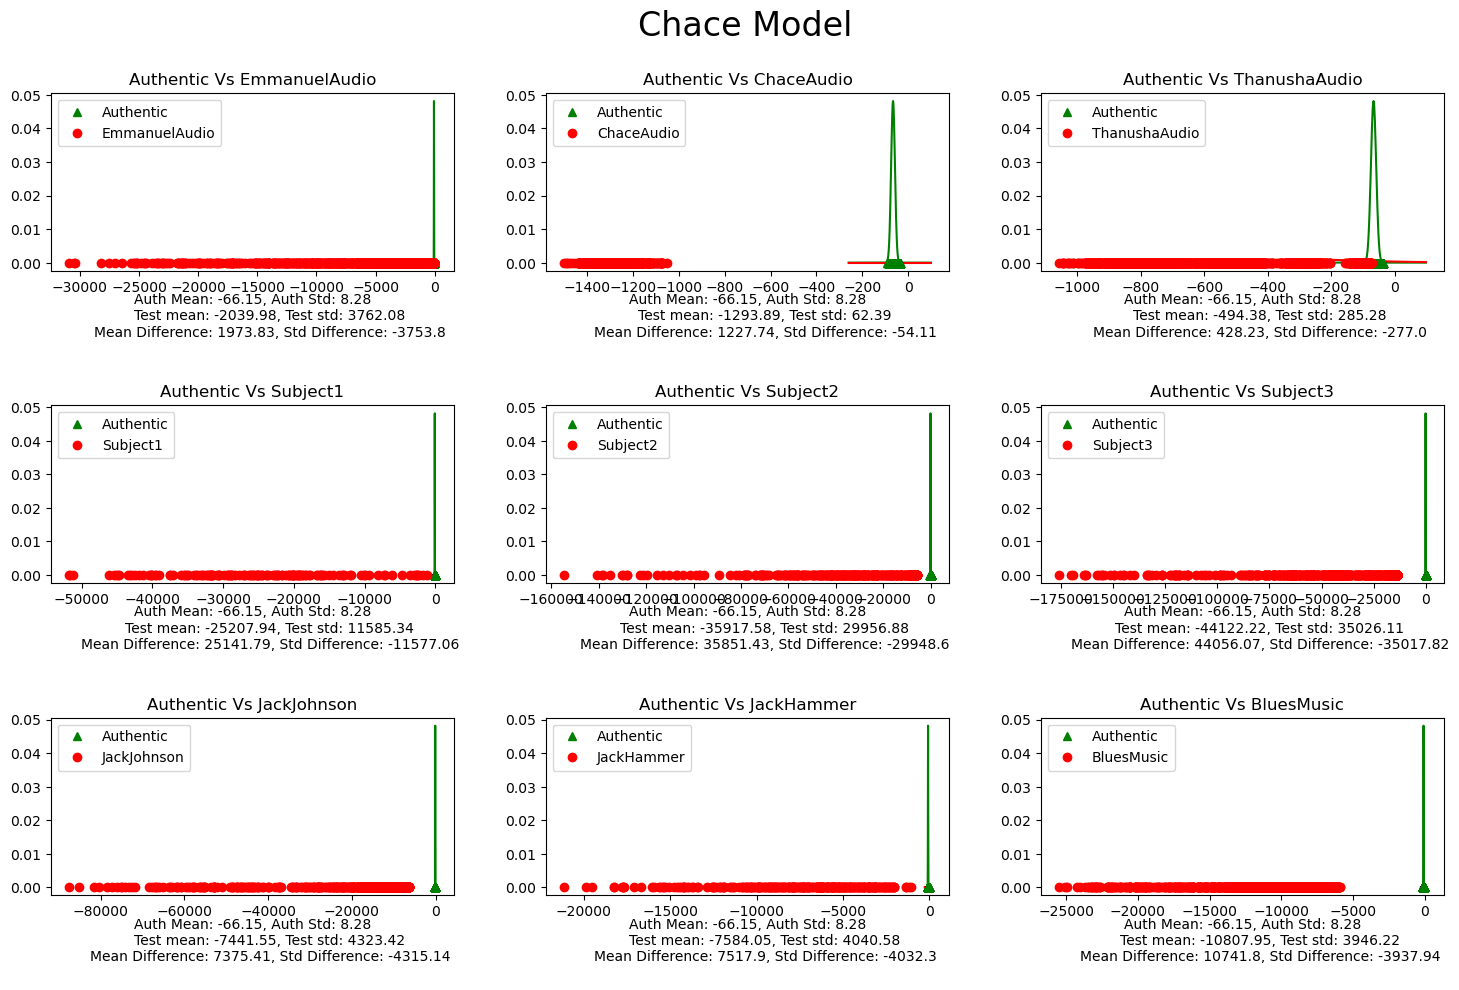

Chace Model Classification: 20 Components
testing using Z-scores and critical value of 0.001



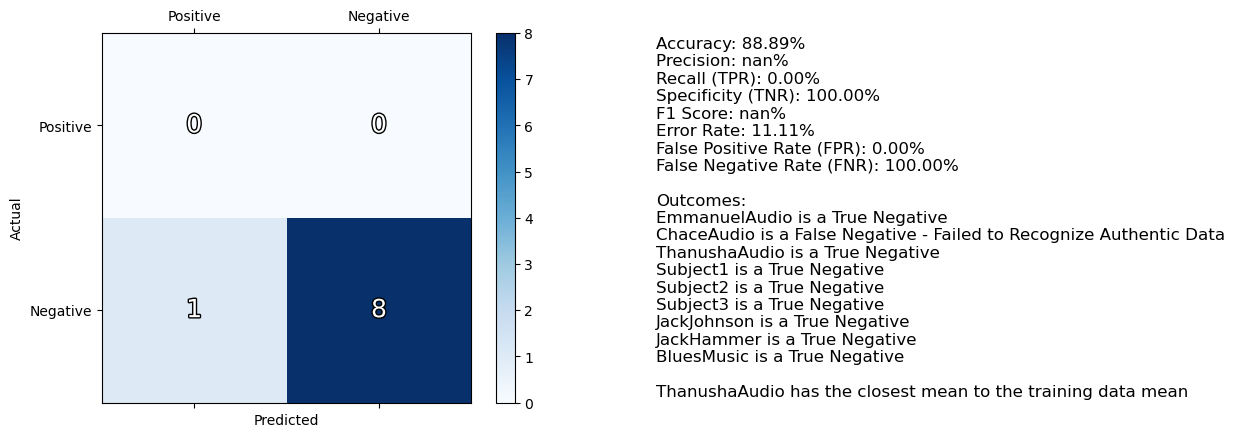

In [14]:
print("Training data is Chaces training data and its authentic testing data is a single shorter audio clip.")
run_analysis("Chace Model", Chace_train_files, imposter_tests, imposter_names, auth_index=1, critical_value=0.001)

Training data is Thanusha training data and its authentic testing data is multiple shorter audio clips.


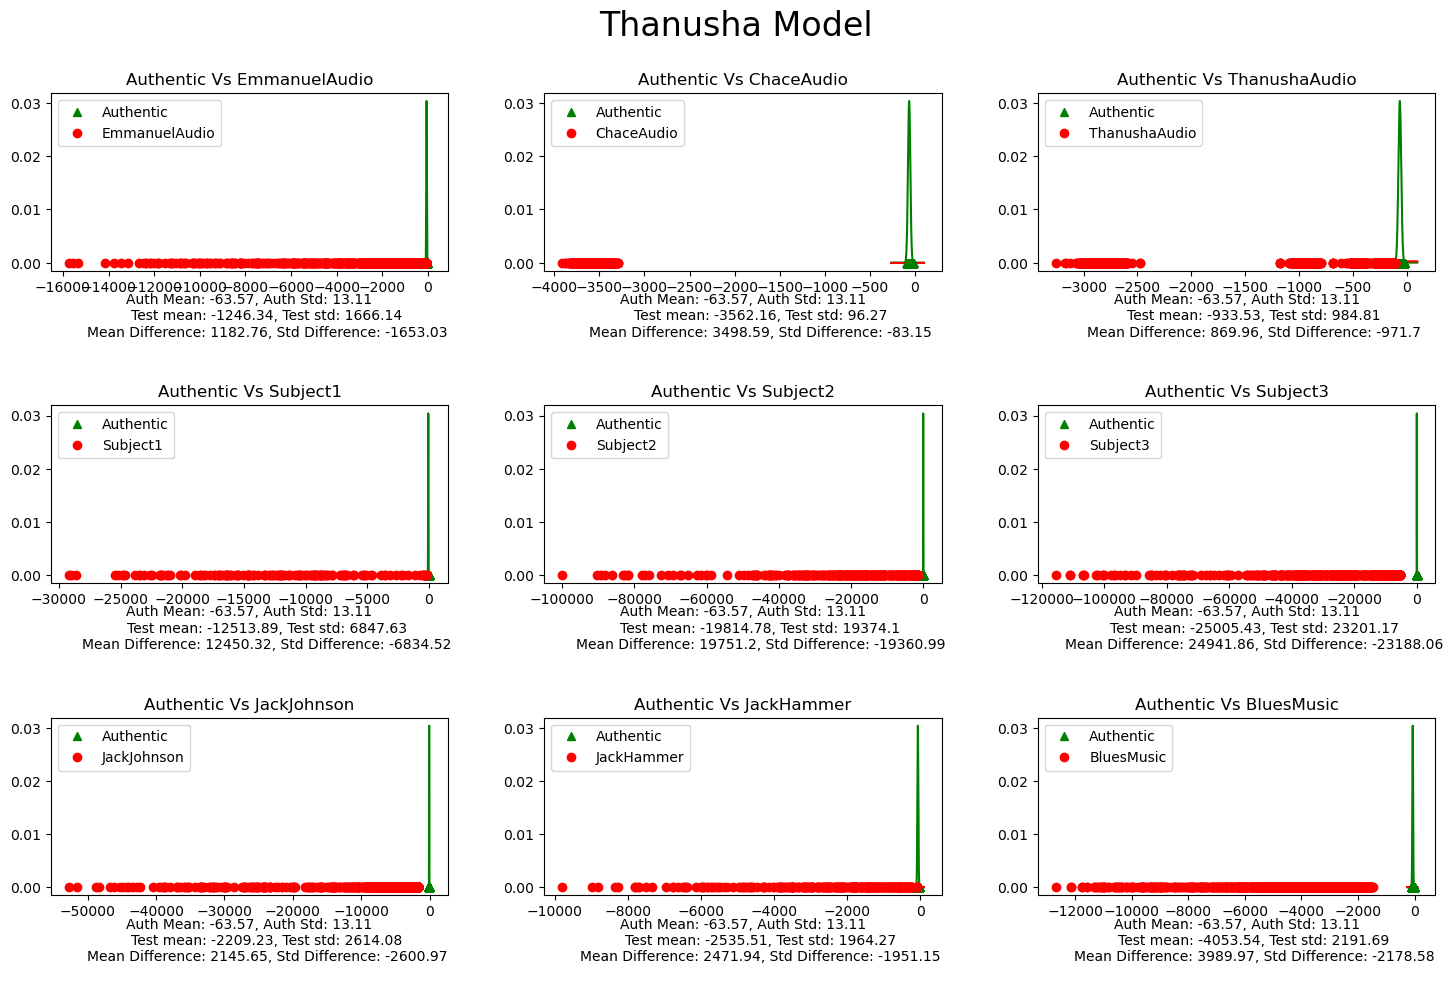

Thanusha Model Classification: 20 Components
testing using Z-scores and critical value of 1.1e-16



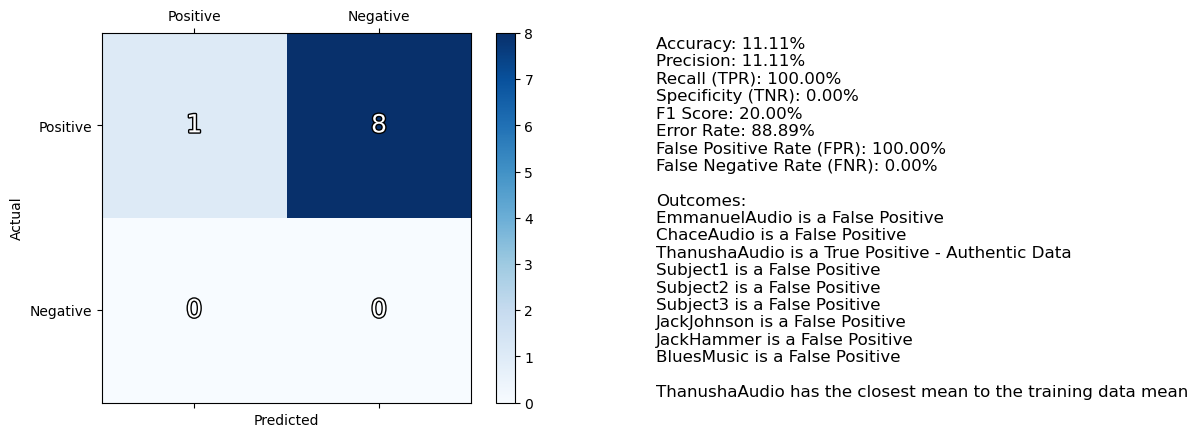

In [15]:
print("Training data is Thanusha training data and its authentic testing data is multiple shorter audio clips.")
run_analysis("Thanusha Model",Thanusha_train_files, imposter_tests, imposter_names, auth_index=2, critical_value=0.00000000000000011)

Training data is Subject 1 training data and its authentic testing data is a single shorter audio clip.


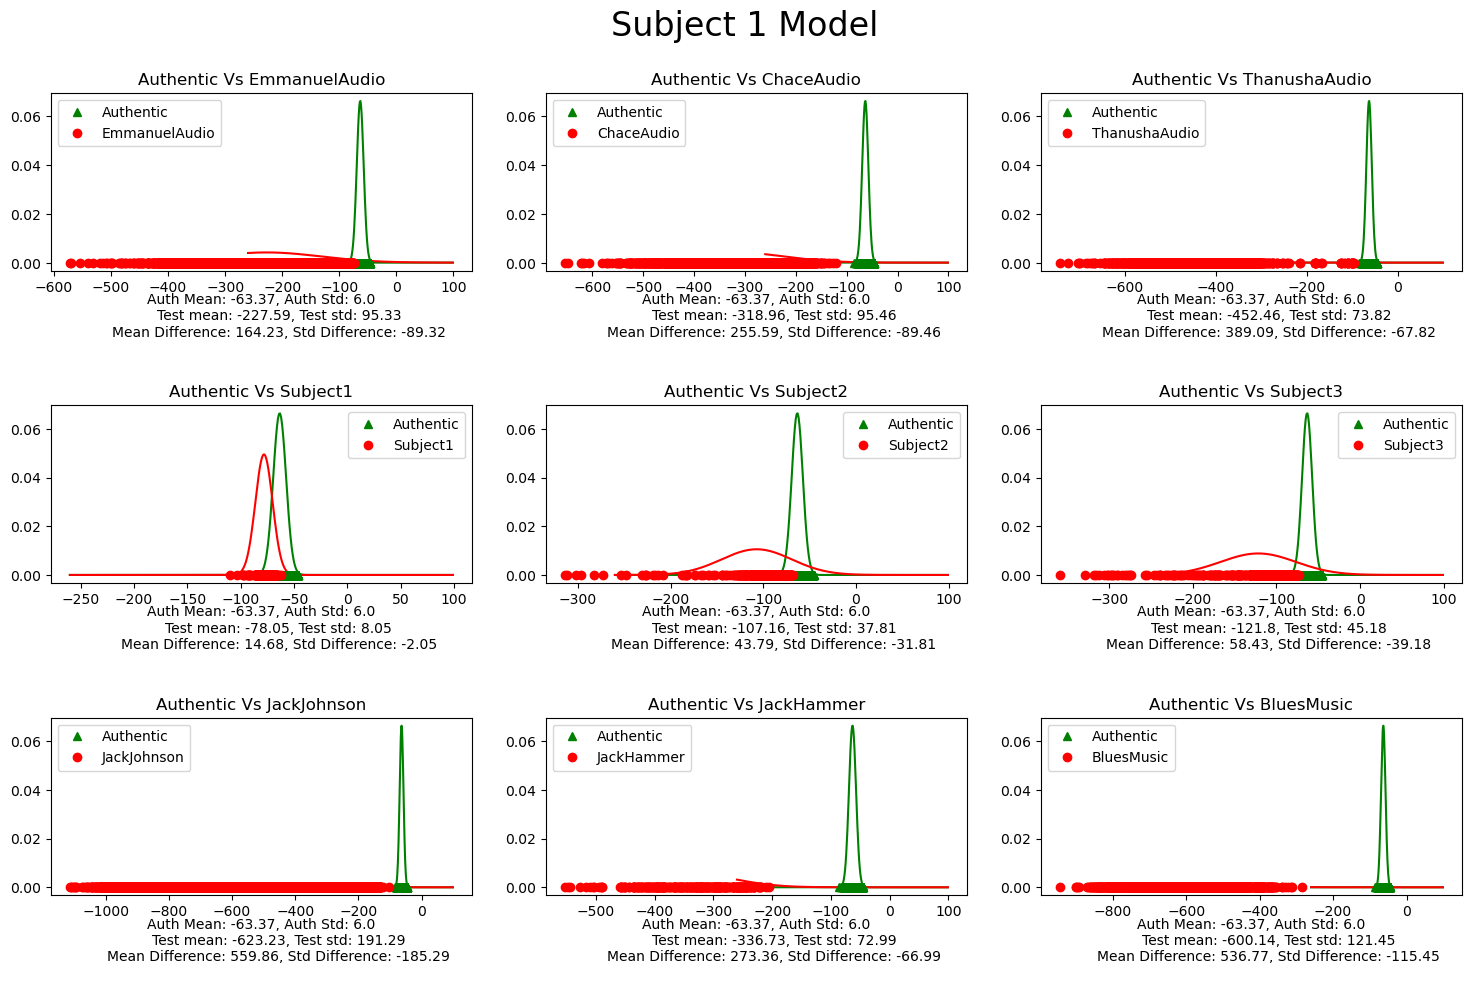

Subject 1 Model Classification: 20 Components
testing using Z-scores and critical value of 0.01



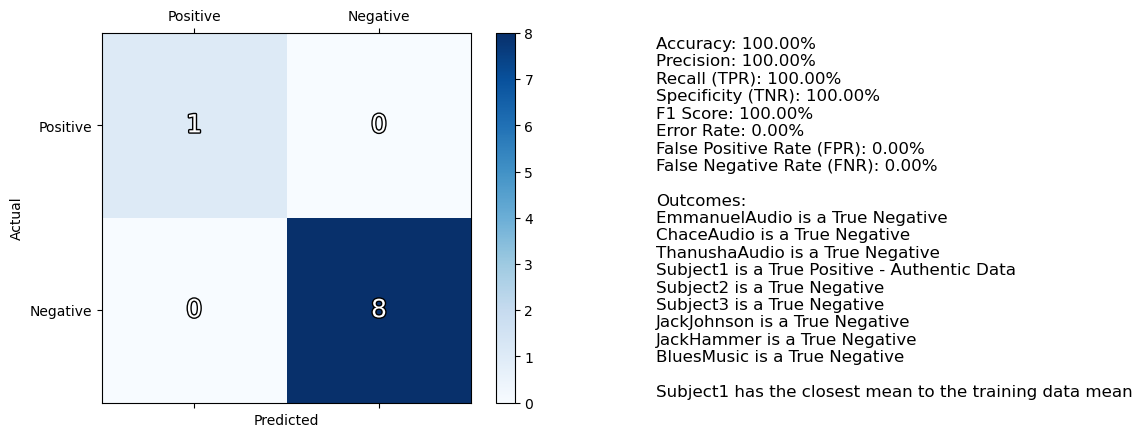

In [16]:
print("Training data is Subject 1 training data and its authentic testing data is a single shorter audio clip.")
run_analysis("Subject 1 Model",Subject1_train_files, imposter_tests, imposter_names, auth_index=3, critical_value=0.01)

Training data is Subject 3 training data and its authentic testing data is a single shorter audio clip.


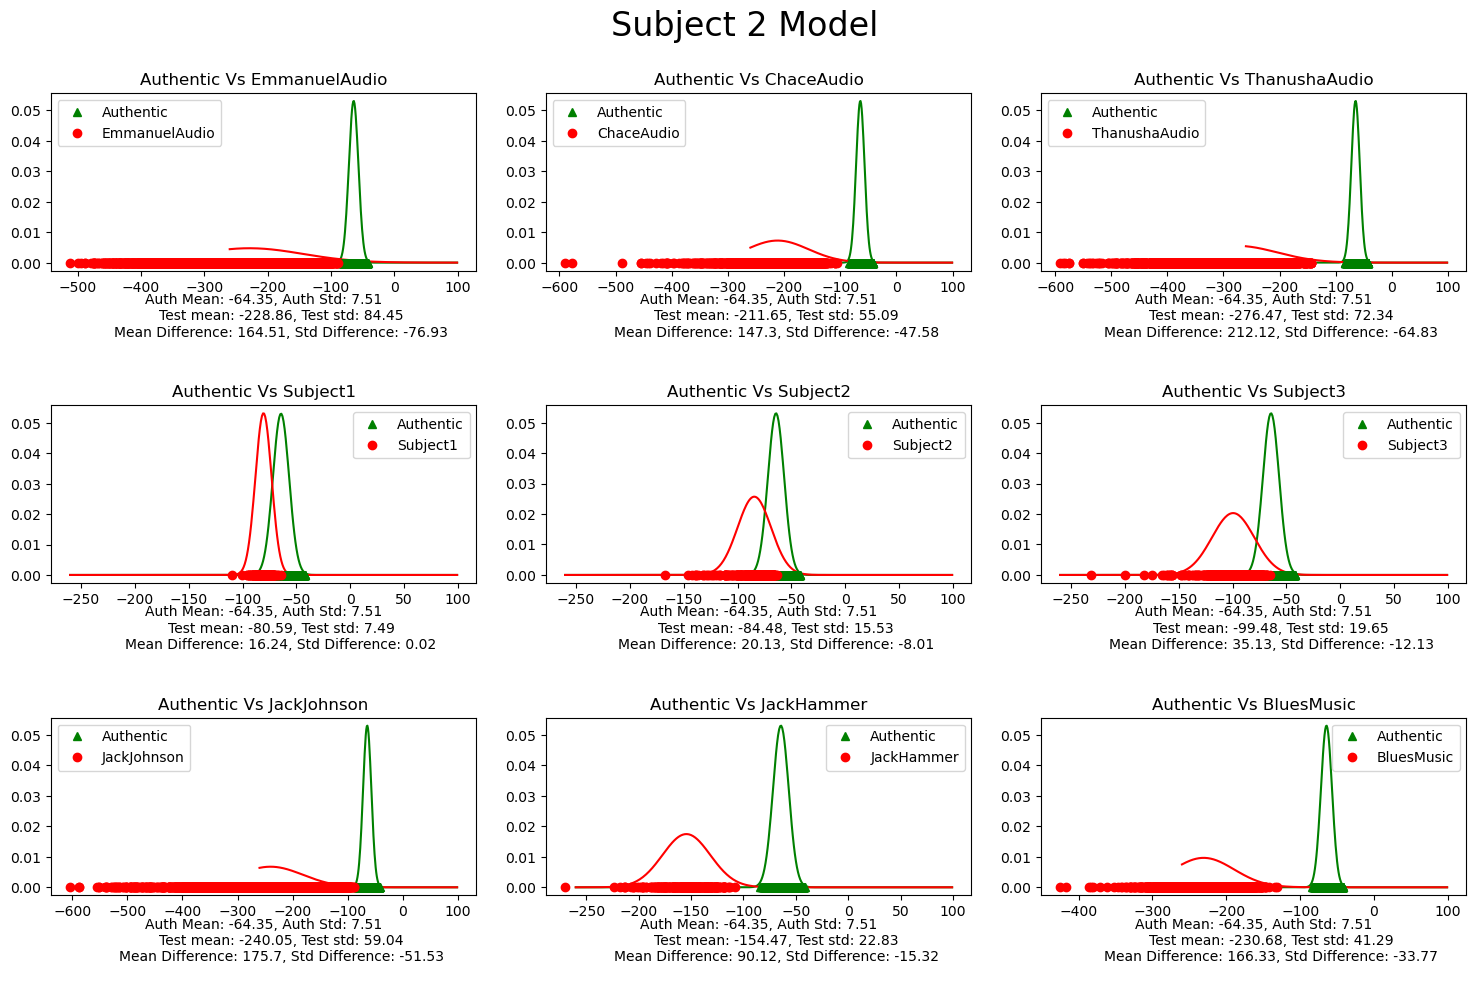

Subject 2 Model Classification: 20 Components
testing using Z-scores and critical value of 0.001



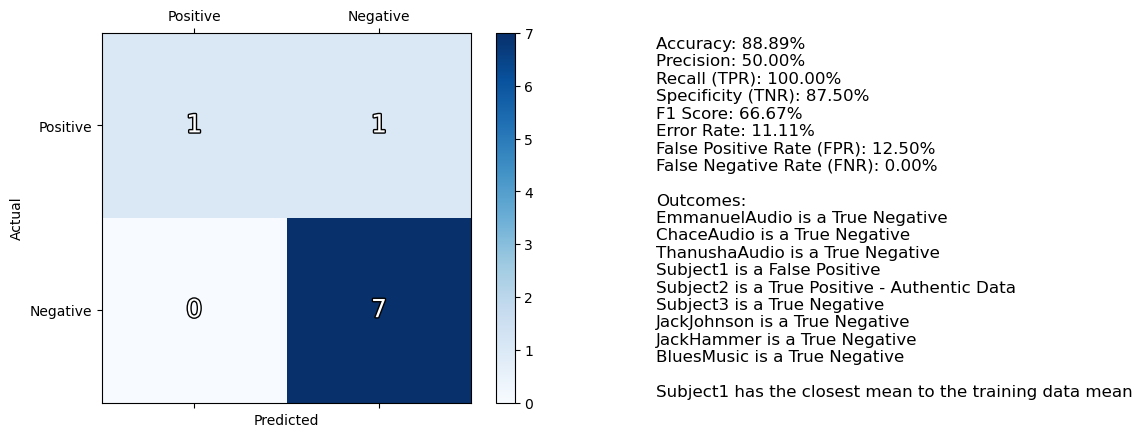

In [17]:
print("Training data is Subject 3 training data and its authentic testing data is a single shorter audio clip.")
run_analysis("Subject 2 Model",Subject2_train_files, imposter_tests, imposter_names, auth_index=4, critical_value=0.001)

Training data is Subject 3 training data and its authentic testing data is a single shorter audio clip.


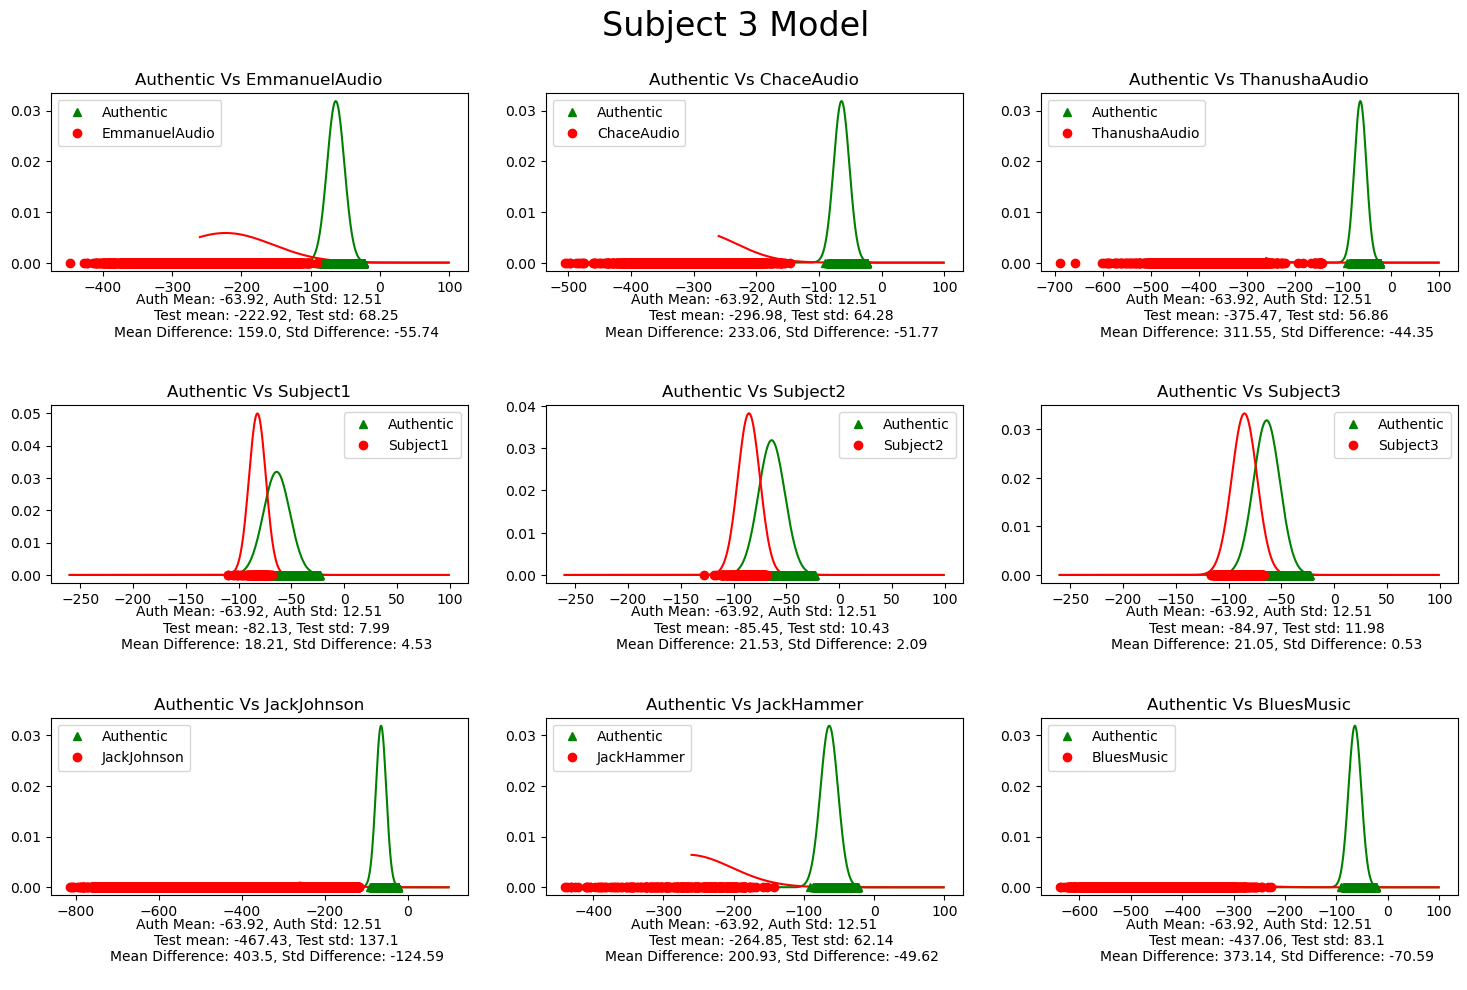

Subject 3 Model Classification: 20 Components
testing using Z-scores and critical value of 0.001



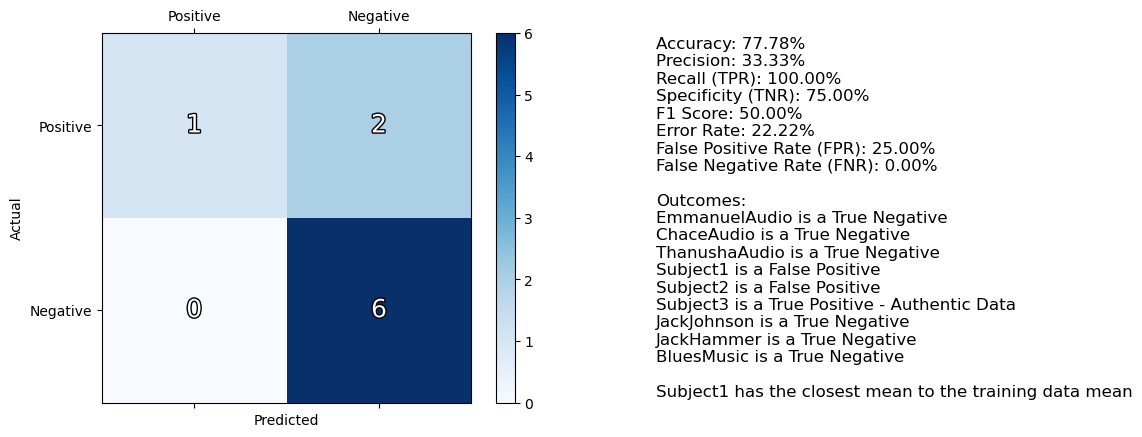

In [18]:
print("Training data is Subject 3 training data and its authentic testing data is a single shorter audio clip.")
run_analysis("Subject 3 Model",Subject3_train_files, imposter_tests, imposter_names, auth_index=5, critical_value=0.001)

Training data is a Jack Johnson song and the authentic testing data is a different song by Jack Johnson


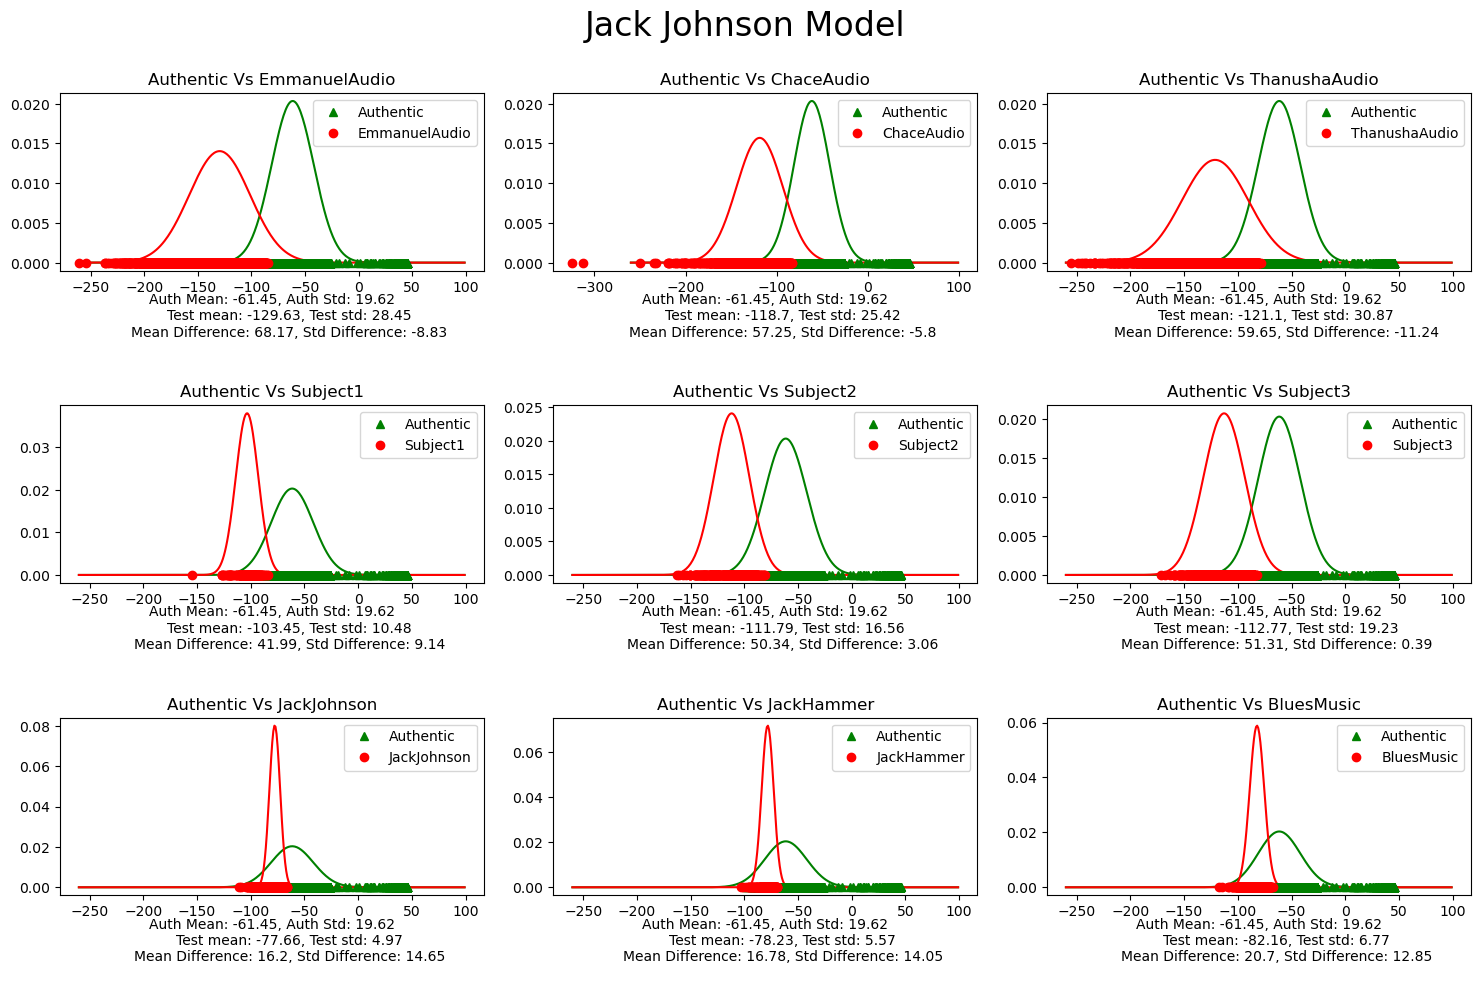

Jack Johnson Model Classification: 20 Components
testing using Z-scores and critical value of 0.05



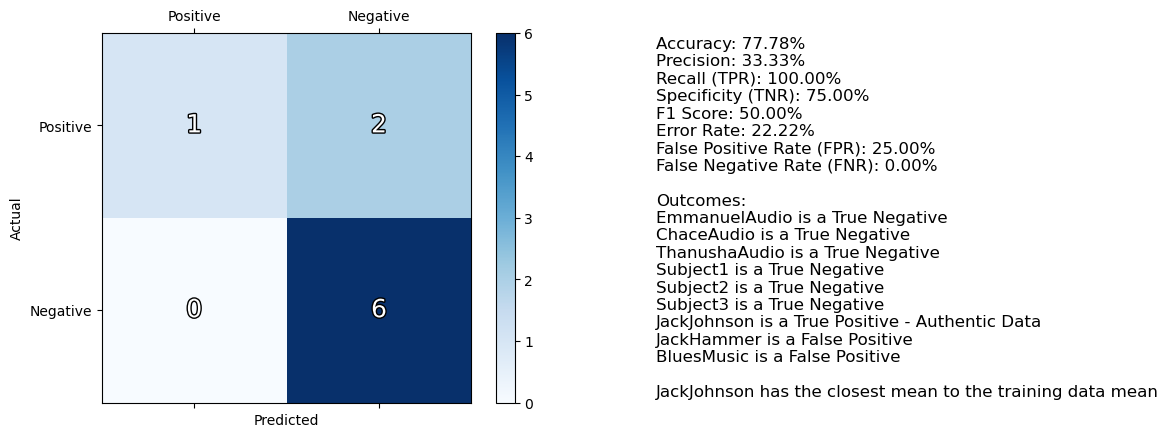

In [31]:
print("Training data is a Jack Johnson song and the authentic testing data is a different song by Jack Johnson")
run_analysis("Jack Johnson Model",JackJohnson_train_files, imposter_tests, imposter_names, auth_index=6, critical_value=0.05)

Training data is a short audio file  and the authentic testing data is the same audio but with a jackhammer playing a the same time


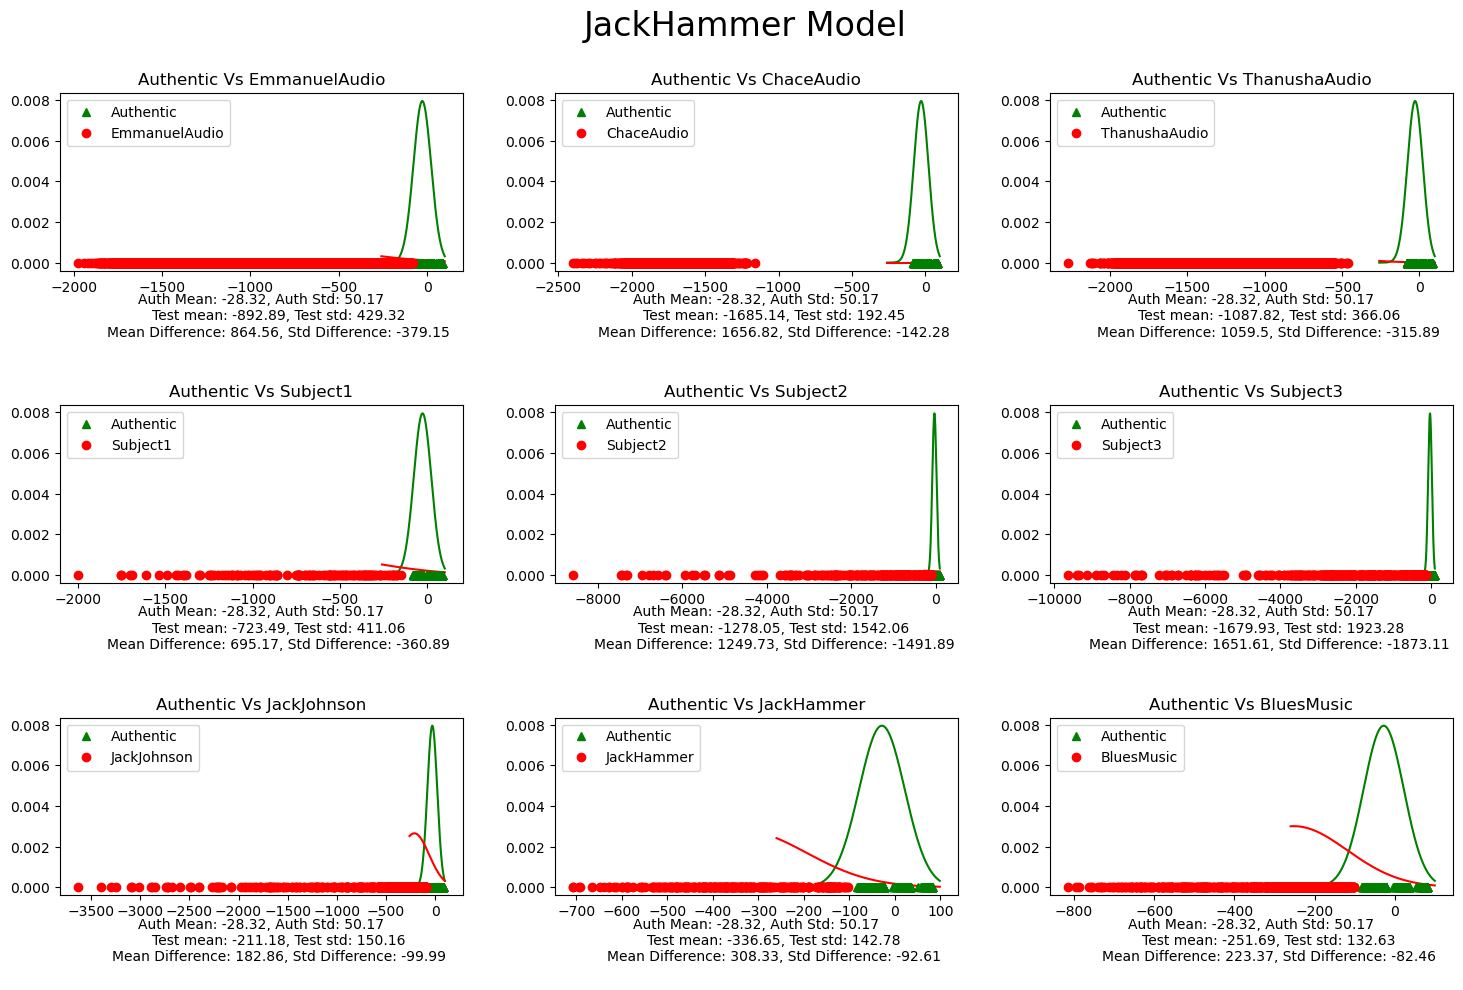

JackHammer Model Classification: 20 Components
testing using Z-scores and critical value of 1e-07



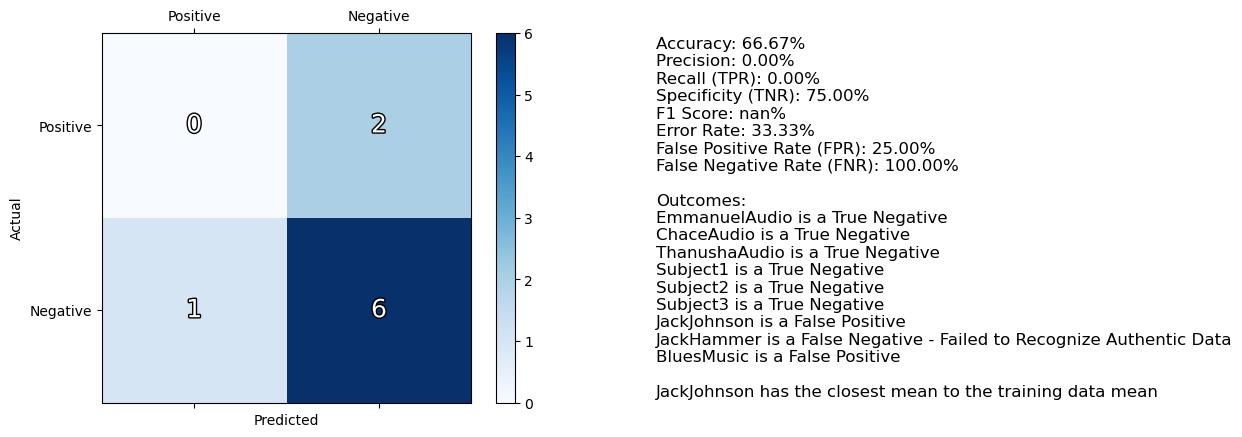

In [20]:
print("Training data is a short audio file  and the authentic testing data is the same audio but with a jackhammer playing a the same time")
run_analysis("JackHammer Model",JackHammer_train_files, imposter_tests, imposter_names, auth_index=7, critical_value=0.0000001)

Training data is a 30 second blues song and the authentic testing data is a different segment of the blues song


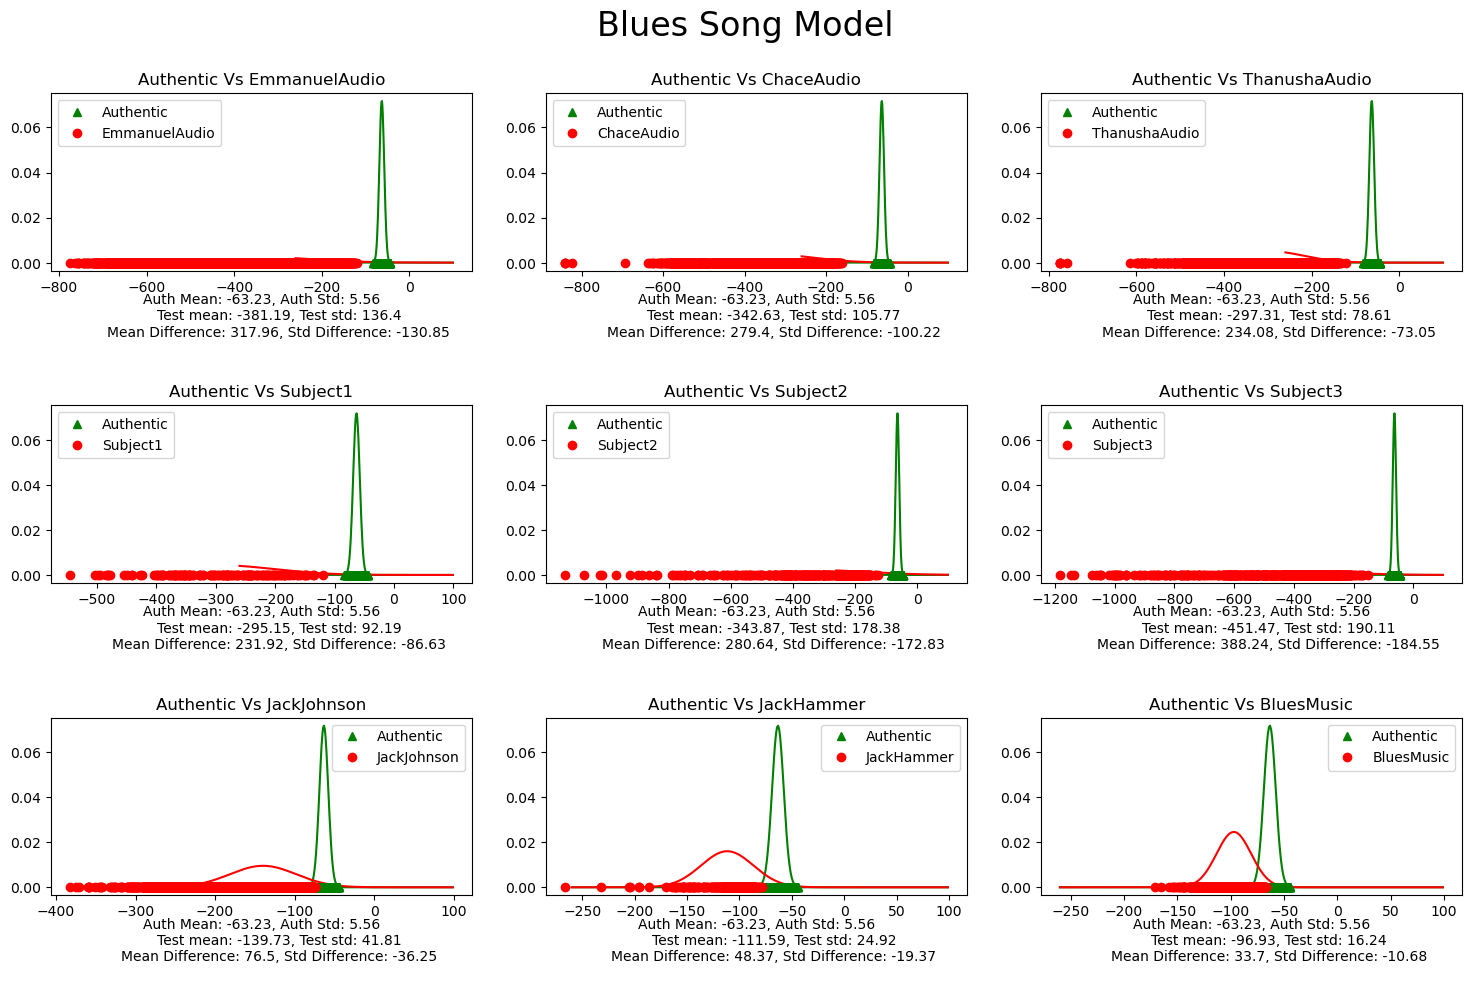

Blues Song Model Classification: 20 Components
testing using Z-scores and critical value of 1e-12



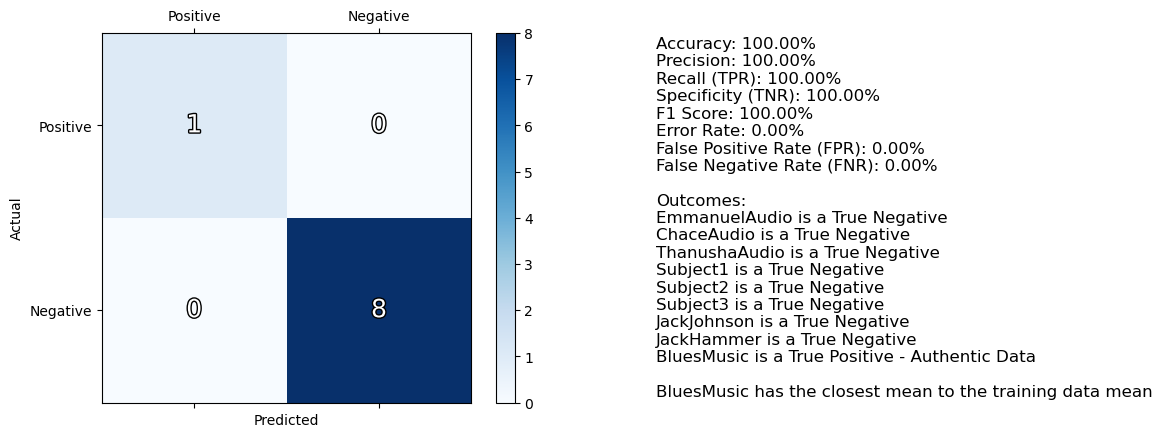

In [34]:
print("Training data is a 30 second blues song and the authentic testing data is a different segment of the blues song")
run_analysis("Blues Song Model",BluesMusic_train_files, imposter_tests, imposter_names, auth_index=8, critical_value=0.000000000001)